In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 12.,8.

import seaborn as sns
import pandas as pd
import wandb

pd.set_option('display.max_columns', None)



In [2]:
api = wandb.Api()
entity, project = "invariance-learners", "iclr2024experiments"  # set to your entity and project 
runs = api.runs(entity + "/" + project)

In [3]:
summary_list, config_list, name_list, tags, ids, states = [], [], [], [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
         if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

    tags.append(run.tags)

    ids.append(run.id)

    states.append(run.state)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list,
    "tags": tags,
    "id": ids,
    "state": states
    })

runs_df

,summary,config,name,tags,id,state
0,"{'best_val_z_kld': 44.91520690917969, 'train/l...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",quiet-smoke-1327,"[angle_sweep, augvae, kataneraz, mnist]",p05crae7,finished
1,"{'γ': 1, 'train/ll': 835.90478515625, 'best_va...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",lunar-planet-1326,"[angle_sweep, augvae, holihojid, mnist]",rz07p15j,finished
2,"{'α': 1, 'best_prior_samples': {'size': 47183,...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",lilac-gorge-1323,"[angle_sweep, augvae, memuvokom, mnist]",zwt89gzh,finished
3,"{'_runtime': 548.3967852592468, 'val/iwlb': 97...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",autumn-voice-1325,"[angle_sweep, augvae, lezokugux, mnist]",vnrql7av,finished
4,"{'β': 1.0000003576278689, 'best_val_ll': 990.3...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",lucky-snowball-1324,"[angle_sweep, augvae, mnist, yasiyajek]",uzsns9yc,finished
...,...,...,...,...,...,...
1289,"{'train/ll': 983.8630981445312, 'train/elbo': ...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",mild-frost-8,"[angle_sweep, baseline, hidden, mnist, vae]",2pz2qcqy,finished
1290,"{'_wandb': {'runtime': 12698}, 'best_val_elbo'...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",dauntless-aardvark-6,"[angle_sweep, baseline, hidden, mnist, vae]",2611qumv,finished
1291,"{'best_prior_samples': {'height': 800, 'sha256...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",still-terrain-2,"[angle_sweep, baseline, hidden, mnist, vae]",1tpxj7i9,finished
1292,"{'train/ll': 930.1177978515624, 'val/elbo': 86...","{'α': 1, 'β': 10, 'γ': 1, 'hais': {'num_steps'...",sparkling-smoke-4,"[angle_sweep, baseline, hidden, mnist, vae]",1ou24u56,finished


In [4]:
df_expanded = runs_df.join(pd.json_normalize(runs_df['summary'], record_prefix='summary.').add_prefix('summary.')).drop('summary', axis='columns')
df_expanded = df_expanded.join(pd.json_normalize(runs_df['config'], record_prefix='config').add_prefix('config.')).drop('config', axis='columns')

df_expanded.columns

Index(['name', 'tags', 'id', 'state', 'summary.best_val_z_kld',
       'summary.train/ll', 'summary.train/elbo', 'summary.val/z_kld',
       'summary.best_val_iwlb', 'summary.val/iwlb',
       ...
       'config.model.Η_given_Xhat.trunk.conv_dims',
       'config.model.Η_given_Xhat.trunk.dense_dims',
       'config.model.Η_given_Xhat.trunk.dropout_rate',
       'config.model.Η_given_Xhat.num_bins',
       'config.model.Η_given_Xhat.num_layers',
       'config.model.Η_given_Xhat.conditioner.hidden_dims',
       'config.model.Η_given_Xhat.conditioner.dropout_rate',
       'config.γ_schedule.alpha', 'config.γ_schedule.decay_steps',
       'config.repeat_after_batch'],
      dtype='object', length=164)

In [5]:
# take only completed runs
df_filtered = df_expanded[df_expanded['state'] == 'finished']

# take only runs with certain tags
tags_to_keep = ['angle_sweep']
df_filtered = df_filtered[df_filtered['tags'].apply(lambda x: all(tag in x for tag in tags_to_keep))]

# take only runs without certain tags
tags_to_remove = ['test', 'hidden', 'ssilvae']
df_filtered = df_filtered[~df_filtered['tags'].apply(lambda x: any(tag in x for tag in tags_to_remove))]

df_filtered

,name,tags,id,state,summary.best_val_z_kld,summary.train/ll,summary.train/elbo,summary.val/z_kld,summary.best_val_iwlb,summary.val/iwlb,summary._timestamp,summary.best_val_ll,summary.best_val_loss,summary.best_val_step,summary.learing_rate,summary.train/z_kld,summary._runtime,summary.val/loss,summary.val/elbo,summary.α,summary.σ_vae,summary.best_val_elbo,summary._step,summary.val/ll,summary.train/loss,summary.β,summary.γ,summary.best_prior_samples._type,summary.best_prior_samples.width,summary.best_prior_samples.format,summary.best_prior_samples.height,summary.best_prior_samples.sha256,summary.best_prior_samples.path,summary.best_prior_samples.size,summary.val_reconstructions.height,summary.val_reconstructions.sha256,summary.val_reconstructions.path,summary.val_reconstructions.size,summary.val_reconstructions._type,summary.val_reconstructions.width,summary.val_reconstructions.format,summary.prior_samples.path,summary.prior_samples.size,summary.prior_samples._type,summary.prior_samples.width,summary.prior_samples.format,summary.prior_samples.height,summary.prior_samples.sha256,summary._wandb.runtime,summary.train/q_η_ce,summary.train/p_q_H_cent,summary.val/q_η_ce,summary.train/xhat_ll,summary.train/η_kld,summary.train/q_H_ent,summary.best_val_p_η_ce,summary.best_val_p_q_H_cent,summary.train/p_η_ce,summary.val/p_q_H_cent,summary.best_val_η_kld,summary.best_val_q_H_ent,summary.best_val_ll_unorm,summary.train/xhat_ll_unorm,summary.σ,summary.val/η_kld,summary.val/p_η_ce,summary.val/xhat_ll,summary.train/ll_unorm,summary.best_val_q_η_ce,summary.best_val_xhat_ll,summary.val/xhat_ll_unorm,summary.val/q_H_ent,summary.val/ll_unorm,summary.best_val_xhat_ll_unorm,summary.hais_mll,config.α,config.β,config.γ,config.seed,config.angle,config.dataset,config.num_trn,config.num_val,config.pp_eval,config.shuffle,config.pp_train,config.run_hais,config.run_iwlb,config.val_split,config.batch_size,config.eval_every,config.model_name,config.optim_name,config.total_steps,config.train_split,config.β_end_value,config.learning_rate,config.batch_size_eval,config.lr_schedule_name,config.β_schedule_name,config.shuffle_buffer_size,config.repeat_after_batching,config.hais.num_steps,config.hais.step_size,config.hais.num_chains,config.hais.num_leapfrog_steps,config.iwlb.num_samples,config.model.X_given_Z.conv_dims,config.model.X_given_Z.dense_dims,config.model.X_given_Z.max_2strides,config.model.Z_given_X.conv_dims,config.model.Z_given_X.dense_dims,config.model.Z_given_X.max_2strides,config.model.latent_dim,config.optim.weight_decay,config.lr_schedule.end_value,config.lr_schedule.peak_value,config.lr_schedule.decay_steps,config.lr_schedule.warmup_steps,config.β_schedule.alpha,config.β_schedule.decay_steps,config.optim,config.γ_mult,config.reset_step,config.lr_schedule,config.partition_fn,config.γ_end_value,config.partition_names,config.per_stage_steps,config.β_schedule_half,config.γ_schedule_half,config.γ_schedule_name,config.lr_schedule_halfs,config.model.bounds,config.model.offset,config.model.Η_given_X.base.conv_dims,config.model.Η_given_X.base.dense_dims,config.model.Η_given_X.base.dropout_rate,config.model.Η_given_X.trunk.conv_dims,config.model.Η_given_X.trunk.dense_dims,config.model.Η_given_X.trunk.dropout_rate,config.model.Η_given_X.num_bins,config.model.Η_given_X.num_layers,config.model.Η_given_X.conditioner.hidden_dims,config.model.Η_given_X.conditioner.dropout_rate,config.model.Xhat_given_Z.conv_dims,config.model.Xhat_given_Z.dense_dims,config.model.Xhat_given_Z.max_2strides,config.model.Z_given_Xhat.conv_dims,config.model.Z_given_Xhat.dense_dims,config.model.Z_given_Xhat.max_2strides,config.model.Η_given_Xhat.base.conv_dims,config.model.Η_given_Xhat.base.dense_dims,config.model.Η_given_Xhat.base.dropout_rate,config.model.Η_given_Xhat.trunk.conv_dims,config.model.Η_given_Xhat.trunk.dense_dims,config.model.Η_given_Xhat.trunk.dropout_rate,config.model.Η_given_Xhat.num_bins,config.model.Η_given_Xhat.num_layers,config.model.Η_given_Xhat.conditioner.hidden_

In [6]:
# replace NaNs in config.shuffle with "loaded"
# df_filtered['config.shuffle'] = df_filtered['config.shuffle'].fillna('loaded')

In [7]:
df_filtered['config.angle'].unique()

array([ 90., 360.,  45.,   5.,  15., 270., 180.,   1., 135.,  30.,   0.])

In [8]:
df_filtered['config.total_steps'].unique()

array([ 7501,  3751, 15001])

In [9]:
df_filtered['config.num_trn'].unique()

array([50000.,  1562.,  3125.,  6250., 12500., 25000.])

In [10]:
df_filtered['size_mult'] = df_filtered['config.model.latent_dim'] // 8

df_filtered['size_mult'].unique()

array([2, 4, 1])

In [11]:
# create a new column which indicates the model type
# this is currently stored in the tags as either "vae", "augvae" or "ssilvae"
df_filtered['model_type'] = df_filtered['tags'].apply(lambda x: [tag for tag in x if tag in ['vae', 'augvae', 'ssilvae']][0])

# now drop all of the ssilvae runs
df_filtered = df_filtered[df_filtered['model_type'] != 'ssilvae']

df_filtered['model_type'].unique()

array(['augvae', 'vae'], dtype=object)

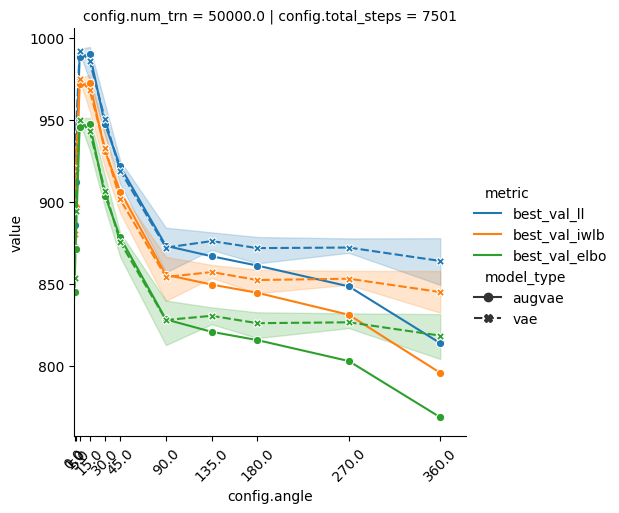

In [14]:
plot_df = df_filtered[[
    'summary.best_val_ll', 'summary.best_val_iwlb', 'summary.best_val_elbo', 'summary.hais_mll', 
    'config.angle', 'config.num_trn', 'config.total_steps', 'model_type', 'size_mult', 'config.repeat_after_batch',
]]

# take only some settings
plot_df = plot_df[
    plot_df['config.total_steps'].isin([7501]) & plot_df['config.num_trn'].isin([50_000]) & plot_df['size_mult'].isin([2])
]

# pivot the data frame so that each of 'summary.best_val_ll', 'summary.best_val_iwlb', 'summary.best_val_elbo', 'summary.hais_mll'
# is a column, and the values are the corresponding values
plot_df = plot_df.melt(
    id_vars=['config.angle', 'config.num_trn', 'config.total_steps', 'model_type', 'size_mult', 'config.repeat_after_batch',],
    value_vars=['summary.best_val_ll', 'summary.best_val_iwlb', 'summary.best_val_elbo'],
    var_name='metric',
    value_name='value'
)

# remove the 'summary.' prefix from the metric names
plot_df['metric'] = plot_df['metric'].str.replace('summary.', '')

# # map config.total_steps to consistent values, if they are in this dict
# new_vals = {30003: 15001, 15003: 7501, 10003: 5001, 7003: 3501}
# plot_df = plot_df.replace({'config.total_steps': new_vals})

g = sns.relplot(
    x="config.angle", y="value", hue="metric", style='model_type', row="config.num_trn", col='config.total_steps',
    # size='config.repeat_after_batch',
    markers=True,
    # palette=sns.color_palette('viridis', as_cmap=True),
    kind="line",
    # col_wrap=2,
    facet_kws=dict(sharey=False, sharex=False),
    # errorbar=None,
    data=plot_df
)
# g.set_axis_labels('Rotation angle', 'Best validation log-likelihood')
# g.set_titles('Total steps: {col_name}')
for axs in g.axes:
    for ax in axs:
        # ax.set(xscale="symlog")
        ax.set_xticks(plot_df['config.angle'].unique())
        ax.set_xticklabels(plot_df['config.angle'].unique(), rotation=45)
        ax.set_xlim(-.1, 385)
plt.show()